 # Hotel Feedback Analysis Using Graph Neural Networks (GNNs) - Phiên bản cải tiến

 ## Lưu ý quan trọng

 Phiên bản này là bản cải tiến với các giải pháp khắc phục vấn đề hiệu suất thấp trong phân loại. Các chỉnh sửa tập trung vào:

 1. Xử lý mất cân bằng dữ liệu
 2. Cải thiện kiến trúc mô hình
 3. Sử dụng focal loss và class weighting
 4. Điều chỉnh ngưỡng dự đoán
 5. Áp dụng early stopping và k-fold validation

 Notebook này giúp bạn chạy mô hình GNN cải tiến trên dữ liệu phản hồi khách sạn.

In [1]:
# %%

!python -m pip install --upgrade pip
!pip install --upgrade pip setuptools wheel
!pip install torch torch-geometric underthesea pandas numpy scikit-learn matplotlib networkx tqdm seaborn
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install maturin

In [2]:
# %%

!pip install underthesea --no-build-isolation

In [3]:
# %%

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
import networkx as nx
import re
import warnings
import hashlib
import random
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
warnings.filterwarnings('ignore')

# Thư viện cần thiết cho GNN
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data

# QUAN TRỌNG: Sử dụng DataLoader từ torch_geometric.loader thay vì từ torch.utils.data
try:
    # PyTorch Geometric phiên bản mới
    from torch_geometric.loader import DataLoader
except ImportError:
    try:
        # PyTorch Geometric phiên bản cũ
        from torch_geometric.data import DataLoader
    except ImportError:
        # Fallback về DataLoader thông thường của PyTorch
        from torch.utils.data import DataLoader
        print("WARNING: Không thể import DataLoader từ PyTorch Geometric. Sử dụng DataLoader từ PyTorch cơ bản có thể gây lỗi khi xử lý đồ thị.")

# Thư viện xử lý ngôn ngữ tiếng Việt
from underthesea import word_tokenize

# Kiểm tra phiên bản PyTorch Geometric
print(f"PyTorch Geometric version: {torch_geometric.__version__}")

# Kiểm tra và sử dụng GPU nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Tạo các thư mục cần thiết
os.makedirs('ml_models', exist_ok=True)
os.makedirs('ml_models/visualizations', exist_ok=True)

PyTorch Geometric version: 2.6.1
Using device: cpu


In [5]:
# %%

# Cấu hình cải tiến
CONFIG = {
    'batch_size': 32,        # Kích thước batch tối ưu từ phân tích
    'hidden_dim': 256,       # Chiều ẩn của mô hình
    'dropout': 0.4,          # Tăng dropout để giảm overfitting
    'learning_rate': 2e-5,   # Learning rate tối ưu từ phân tích
    'weight_decay': 5e-5,    # Tăng regularization
    'epochs': 100,           # Số epoch tối đa
    'window_size': 3,        # Cửa sổ đồng xuất hiện từ trong đồ thị
    'embedding_size': 100,   # Kích thước vector biểu diễn cho từ
    'early_stopping_patience': 100,  # Số epoch đợi trước khi dừng sớm
    'prediction_threshold': 0.3,    # Ngưỡng dự đoán thấp hơn để tăng recall
    'focal_loss_gamma': 2.0,        # Tham số gamma cho focal loss
    'class_balancing': 'undersample',  # Phương pháp cân bằng dữ liệu 
    'seed': 42               # Hạt giống cho khả năng tái tạo
}

In [6]:
# %%

def ensure_directories():
    """
    Đảm bảo tất cả các thư mục cần thiết tồn tại
    """
    # Tạo thư mục ml_models nếu chưa tồn tại
    os.makedirs('ml_models', exist_ok=True)
    # Tạo thư mục visualizations nếu chưa tồn tại
    os.makedirs(os.path.join('ml_models', 'visualizations'), exist_ok=True)
    # Kiểm tra quyền ghi vào các thư mục
    try:
        # Kiểm tra quyền ghi bằng cách tạo và xóa một file tạm
        test_file = os.path.join('ml_models', 'test_write.txt')
        with open(test_file, 'w') as f:
            f.write('test')
        os.remove(test_file)
        print("Directory 'ml_models' exists and has write permissions.")
        
        test_file = os.path.join('ml_models', 'visualizations', 'test_write.txt')
        with open(test_file, 'w') as f:
            f.write('test')
        os.remove(test_file)
        print("Directory 'ml_models/visualizations' exists and has write permissions.")
    except Exception as e:
        print(f"Error checking directory permissions: {e}")

In [7]:
# %%

def load_data(train_path='data/train.csv', val_path='data/val.csv', test_path='data/test.csv'):
    """
    Đọc dữ liệu từ các file CSV
    """
    print("Loading data...")
    try:
        train_data = pd.read_csv(train_path)
        val_data = pd.read_csv(val_path)
        test_data = pd.read_csv(test_path)
        
        # Hiển thị thông tin về dữ liệu
        print(f"Train data: {train_data.shape[0]} samples")
        print(f"Validation data: {val_data.shape[0]} samples")
        print(f"Test data: {test_data.shape[0]} samples")
        
        # Hiển thị tên cột để xác minh cấu trúc
        print(f"Columns in train data: {train_data.columns.tolist()}")
        
        # Trích xuất reviews và labels
        # Cột 'Review' chứa văn bản phản hồi, các cột còn lại là nhãn
        train_reviews = train_data['Review'].tolist()
        train_labels = train_data.drop(['Review'], axis=1, errors='ignore').values
        
        val_reviews = val_data['Review'].tolist()
        val_labels = val_data.drop(['Review'], axis=1, errors='ignore').values
        
        test_reviews = test_data['Review'].tolist()
        test_labels = test_data.drop(['Review'], axis=1, errors='ignore').values
        
        # Lấy tên của các nhãn
        label_names = train_data.drop(['Review'], axis=1, errors='ignore').columns.tolist()
        print(f"Number of labels: {len(label_names)}")
        
        return train_reviews, train_labels, val_reviews, val_labels, test_reviews, test_labels, label_names
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

In [8]:
# %%

def analyze_label_distribution(train_labels, label_names):
    """
    Phân tích sự phân bố của các nhãn để hiểu về sự mất cân bằng
    """
    print("Analyzing label distribution...")
    
    # Tính số lượng mẫu dương cho mỗi nhãn
    positive_counts = np.sum(train_labels, axis=0)
    total_samples = train_labels.shape[0]
    
    # Tạo DataFrame để dễ hiển thị
    label_stats = pd.DataFrame({
        'Label': label_names,
        'Positive_Samples': positive_counts,
        'Positive_Ratio': positive_counts / total_samples,
        'Negative_Samples': total_samples - positive_counts,
        'Negative_Ratio': 1 - (positive_counts / total_samples)
    })
    
    # Hiển thị thống kê
    print(label_stats)
    
    # Vẽ biểu đồ phân bố
    plt.figure(figsize=(12, 6))
    plt.bar(label_names, positive_counts)
    plt.axhline(y=total_samples/2, color='r', linestyle='-', label='50% mark')
    plt.xticks(rotation=90)
    plt.title('Positive Sample Count per Label')
    plt.xlabel('Labels')
    plt.ylabel('Number of Positive Samples')
    plt.tight_layout()
    plt.savefig('ml_models/visualizations/label_distribution.png')
    plt.show()
    
    # Tìm các nhãn mất cân bằng nghiêm trọng (ít hơn 10% mẫu dương)
    imbalanced_labels = label_stats[label_stats['Positive_Ratio'] < 0.1]
    if not imbalanced_labels.empty:
        print("\nSeverely imbalanced labels (less than 10% positive samples):")
        print(imbalanced_labels[['Label', 'Positive_Ratio']])
    
    return label_stats

In [9]:
# %%

def balance_dataset(train_reviews, train_labels, label_names, strategy='undersample'):
    """
    Cân bằng dữ liệu sử dụng undersampling hoặc oversampling
    """
    print(f"Balancing dataset using {strategy}...")
    
    # Xác định các nhãn mất cân bằng nghiêm trọng (dưới 10% dương hoặc trên 90% dương)
    positive_ratios = np.sum(train_labels, axis=0) / train_labels.shape[0]
    imbalanced_idxs = np.where((positive_ratios < 0.1) | (positive_ratios > 0.9))[0]
    
    if len(imbalanced_idxs) == 0:
        print("No severely imbalanced labels found, using original dataset")
        return train_reviews, train_labels
    
    print(f"Found {len(imbalanced_idxs)} severely imbalanced labels")
    
    # Khởi tạo dữ liệu cân bằng
    balanced_reviews = []
    balanced_labels = []
    
    # Xử lý cân bằng cho từng nhãn mất cân bằng
    for label_idx in imbalanced_idxs:
        pos_indices = np.where(train_labels[:, label_idx] == 1)[0]
        neg_indices = np.where(train_labels[:, label_idx] == 0)[0]
        
        label_name = label_names[label_idx]
        print(f"Balancing label '{label_name}': {len(pos_indices)} positive, {len(neg_indices)} negative samples")
        
        if strategy == 'undersample':
            # Undersample dữ liệu đa số
            target_count = min(len(pos_indices), len(neg_indices))
            target_count = max(target_count, 100)  # Đảm bảo ít nhất 100 mẫu
            
            if len(pos_indices) > target_count:
                pos_indices = resample(pos_indices, n_samples=target_count, random_state=CONFIG['seed'])
            if len(neg_indices) > target_count:
                neg_indices = resample(neg_indices, n_samples=target_count, random_state=CONFIG['seed'])
        
        elif strategy == 'oversample':
            # Oversample dữ liệu thiểu số
            target_count = max(len(pos_indices), len(neg_indices))
            target_count = min(target_count, 1000)  # Giới hạn để tránh quá nhiều duplicates
            
            if len(pos_indices) < target_count:
                pos_indices = resample(pos_indices, n_samples=target_count, random_state=CONFIG['seed'], replace=True)
            if len(neg_indices) < target_count:
                neg_indices = resample(neg_indices, n_samples=target_count, random_state=CONFIG['seed'], replace=True)
        
        # Kết hợp các chỉ số
        balanced_indices = np.concatenate([pos_indices, neg_indices])
        
        # Thêm vào dữ liệu cân bằng
        for idx in balanced_indices:
            if idx < len(train_reviews):  # Đảm bảo index hợp lệ
                balanced_reviews.append(train_reviews[idx])
                balanced_labels.append(train_labels[idx])
    
    # Chuyển đổi sang numpy arrays
    balanced_labels = np.array(balanced_labels)
    
    # Kiểm tra lại tỉ lệ sau khi cân bằng
    new_positive_ratios = np.sum(balanced_labels, axis=0) / balanced_labels.shape[0]
    print("\nLabel ratios after balancing:")
    for i, label in enumerate(label_names):
        print(f"  {label}: {new_positive_ratios[i]:.4f}")
    
    print(f"Original dataset: {len(train_reviews)} samples")
    print(f"Balanced dataset: {len(balanced_reviews)} samples")
    
    return balanced_reviews, balanced_labels

In [10]:
# %%

def augment_text_data(reviews, labels, augmentation_factor=1):
    """
    Làm giàu dữ liệu văn bản bằng cách thay thế từ, xáo trộn câu, v.v.
    """
    print(f"Augmenting text data with factor {augmentation_factor}...")
    
    augmented_reviews = []
    augmented_labels = []
    
    # Thêm reviews gốc
    augmented_reviews.extend(reviews)
    augmented_labels.extend(labels)
    
    if augmentation_factor <= 0:
        return augmented_reviews, np.array(augmented_labels)
    
    # Tạo phiên bản mới cho mỗi review
    for idx, review in enumerate(tqdm(reviews, desc="Augmenting data")):
        for _ in range(augmentation_factor):
            # Tokenize review
            words = word_tokenize(review.lower())
            
            if len(words) <= 3:
                # Bỏ qua reviews quá ngắn
                continue
                
            # Tạo phiên bản mới bằng cách áp dụng một trong các kỹ thuật sau
            technique = np.random.choice(['shuffle', 'drop', 'replace'])
            
            if technique == 'shuffle' and len(words) > 5:
                # Xáo trộn một phần của review
                shuffle_idx = np.random.randint(0, len(words) - 5)
                segment_len = min(5, len(words) - shuffle_idx)
                segment = words[shuffle_idx:shuffle_idx+segment_len]
                random.shuffle(segment)
                words[shuffle_idx:shuffle_idx+segment_len] = segment
                
            elif technique == 'drop' and len(words) > 7:
                # Bỏ một số từ ngẫu nhiên (không quá 20%)
                drop_count = max(1, int(len(words) * 0.2))
                drop_indices = sorted(random.sample(range(len(words)), drop_count), reverse=True)
                for drop_idx in drop_indices:
                    words.pop(drop_idx)
                    
            # Tạo review mới
            new_review = ' '.join(words)
            augmented_reviews.append(new_review)
            augmented_labels.append(labels[idx])
    
    print(f"After augmentation: {len(augmented_reviews)} samples")
    return augmented_reviews, np.array(augmented_labels)

In [11]:
# %%

def get_word_vector(word, embedding_size, seed=42):
    """
    Tạo một vector đặc trưng cho từ dựa trên hàm băm nhất quán
    """
    # Đặt hạt giống ngẫu nhiên theo từ để tạo tính nhất quán
    hash_value = int(hashlib.md5(word.encode()).hexdigest(), 16) % (2**32)
    np.random.seed(hash_value + seed)
    # Tạo vector ngẫu nhiên
    vector = np.random.normal(0, 1, embedding_size)
    # Chuẩn hóa vector
    return vector / (np.linalg.norm(vector) + 1e-8)  # Tránh chia cho 0

def preprocess_data(train_reviews, val_reviews, test_reviews, config, device):
    """
    Tiền xử lý dữ liệu văn bản sử dụng phương pháp đơn giản
    """
    print("Preprocessing data...")
    
    try:
        # Đặt hạt giống cho tính nhất quán
        random.seed(config['seed'])
        np.random.seed(config['seed'])
        
        # Thu thập tất cả các từ xuất hiện trong các reviews
        print("Building vocabulary...")
        all_words = set()
        all_tokens = []
        
        # Tokenize tất cả reviews
        for reviews in [train_reviews, val_reviews, test_reviews]:
            for review in tqdm(reviews, desc="Tokenizing reviews"):
                tokens = word_tokenize(review.lower())
                all_tokens.append(tokens)
                all_words.update(tokens)
        
        # Tạo từ điển từ -> index
        print("Creating word index and embeddings...")
        word_to_idx = {word: idx for idx, word in enumerate(sorted(all_words))}
        embedding_size = config['embedding_size']
        
        # Tạo vector đặc trưng cho mỗi từ
        word_embeddings = {}
        for word in tqdm(word_to_idx.keys(), desc="Creating embeddings"):
            word_embeddings[word] = get_word_vector(word, embedding_size, config['seed'])
        
        print(f"Vocabulary size: {len(word_to_idx)}")
        
        # Chuyển reviews thành sequences và vectors
        print("Processing datasets...")
        train_processed = []
        val_processed = []
        test_processed = []
        
        # Hàm tạo vector biểu diễn đặc trưng cho mỗi review
        def process_review(review):
            tokens = word_tokenize(review.lower())
            # Lấy vector biểu diễn của các từ trong review
            vectors = [word_embeddings[token] for token in tokens if token in word_embeddings]
            
            # Nếu không có từ nào, trả về vector không để tránh lỗi
            if not vectors:
                # Tạo một ma trận trống với kích thước mặc định
                empty_matrix = np.zeros((1, embedding_size))
                return [], empty_matrix
            
            # Kiểm tra và đảm bảo vectors có cùng chiều dài
            for i, vec in enumerate(vectors):
                if len(vec.shape) != 1 or vec.shape[0] != embedding_size:
                    vectors[i] = np.zeros(embedding_size)  # Thay thế bằng vector zero
            
            # Chuyển thành mảng numpy và kiểm tra kích thước
            try:
                # Tạo mảng numpy từ danh sách vectors
                embeddings = np.array(vectors)
                
                # Kiểm tra hình dạng của embeddings
                if len(embeddings.shape) != 2:
                    # Tạo mảng mới với kích thước đúng
                    correct_embeddings = np.zeros((len(vectors), embedding_size))
                    # Sao chép từng vector một khi có thể
                    for i, vec in enumerate(vectors):
                        if i < correct_embeddings.shape[0]:
                            correct_embeddings[i, :min(len(vec), embedding_size)] = vec[:embedding_size]
                    embeddings = correct_embeddings
                
                # Kiểm tra kích thước của chiều thứ hai
                if embeddings.shape[1] != embedding_size:
                    # Resize the embeddings to have the correct dimension
                    correct_embeddings = np.zeros((embeddings.shape[0], embedding_size))
                    for i in range(embeddings.shape[0]):
                        correct_embeddings[i, :min(embeddings.shape[1], embedding_size)] = embeddings[i, :min(embeddings.shape[1], embedding_size)]
                    embeddings = correct_embeddings
                
                return tokens, embeddings
                
            except Exception as e:
                print(f"Error creating embeddings array: {e}")
                # Fallback to a safe default
                empty_matrix = np.zeros((1, embedding_size))
                return tokens, empty_matrix
        
        # Show sample processing to verify
        if train_reviews:
            print("\nSample review processing:")
            sample_review = train_reviews[0]
            sample_tokens, sample_embeddings = process_review(sample_review)
            print(f"Review: '{sample_review[:50]}...'")
            print(f"Tokens: {len(sample_tokens)}")
            print(f"Embeddings shape: {sample_embeddings.shape}")
        
        # Xử lý tất cả reviews
        for review in tqdm(train_reviews, desc="Processing train set"):
            tokens, embeddings = process_review(review)
            train_processed.append((tokens, embeddings))
        
        for review in tqdm(val_reviews, desc="Processing validation set"):
            tokens, embeddings = process_review(review)
            val_processed.append((tokens, embeddings))
        
        for review in tqdm(test_reviews, desc="Processing test set"):
            tokens, embeddings = process_review(review)
            test_processed.append((tokens, embeddings))
        
        # Kiểm tra dữ liệu đã xử lý
        print("\nProcessed data summary:")
        print(f"Train set: {len(train_processed)} reviews")
        print(f"Validation set: {len(val_processed)} reviews")
        print(f"Test set: {len(test_processed)} reviews")
        
        return train_processed, val_processed, test_processed, word_to_idx, word_embeddings
    except Exception as e:
        print(f"Error preprocessing data: {e}")
        import traceback
        traceback.print_exc()
        raise

In [12]:
# %%

def create_graph_datasets(train_processed, val_processed, test_processed, train_labels, val_labels, test_labels, word_to_idx, word_embeddings, config):
    """
    Tạo bộ dữ liệu đồ thị cho mô hình GNN
    """
    print("Creating graph datasets...")
    
    def create_graph(tokens, embeddings, labels):
        """
        Tạo đồ thị từ tokens và embeddings
        """
        try:
            # Kiểm tra dữ liệu đầu vào
            if len(tokens) == 0 or embeddings.size == 0:
                # Trường hợp không có từ nào, tạo đồ thị với 1 node mặc định
                default_node = np.zeros((1, config['embedding_size']))
                node_features = torch.tensor(default_node, dtype=torch.float)
                edge_index = torch.zeros((2, 0), dtype=torch.long)  # Không có cạnh
                y = torch.tensor(labels, dtype=torch.float)
                return Data(x=node_features, edge_index=edge_index, y=y)
            
            # Kiểm tra kích thước của embedding
            if len(embeddings.shape) != 2:
                print(f"Warning: Unexpected embedding shape: {embeddings.shape}. Reshaping...")
                # Đảm bảo embeddings có dạng 2D (n_tokens x embedding_dim)
                if len(embeddings.shape) == 1:
                    embeddings = embeddings.reshape(1, -1)
                else:
                    # Trường hợp khác, thử reshape thành mảng 2D
                    total_elements = np.prod(embeddings.shape)
                    target_shape = (embeddings.shape[0], total_elements // embeddings.shape[0])
                    try:
                        embeddings = embeddings.reshape(target_shape)
                    except ValueError:
                        # Nếu không thể reshaping, tạo một mảng mới
                        print(f"Cannot reshape to {target_shape}, creating a new array")
                        embeddings = np.zeros((1, config['embedding_size']))

            # Tạo các node trong đồ thị (mỗi node là một từ)
            node_features = torch.tensor(embeddings, dtype=torch.float)
            
            # Tạo các cạnh dựa trên cửa sổ đồng xuất hiện
            window_size = config['window_size']
            edges = []
            for i in range(len(tokens)):
                for j in range(max(0, i-window_size), min(len(tokens), i+window_size+1)):
                    if i != j:  # Không tạo cạnh nối với chính nó
                        edges.append((i, j))
            
            # Chuyển danh sách cạnh thành tensor
            if edges:
                edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            else:
                # Nếu không có cạnh, tạo một tensor rỗng
                edge_index = torch.zeros((2, 0), dtype=torch.long)
            
            # Tạo nhãn
            y = torch.tensor(labels, dtype=torch.float)
            
            # Tạo đồ thị
            graph = Data(x=node_features, edge_index=edge_index, y=y)
            return graph
        
        except Exception as e:
            print(f"Error creating graph: {e}")
            import traceback
            traceback.print_exc()
            
            # Tạo một đồ thị mặc định để không làm gián đoạn quá trình
            default_node = np.zeros((1, config['embedding_size']))
            node_features = torch.tensor(default_node, dtype=torch.float)
            edge_index = torch.zeros((2, 0), dtype=torch.long)  # Không có cạnh
            y = torch.tensor(labels, dtype=torch.float)
            return Data(x=node_features, edge_index=edge_index, y=y)
    
    # Tạo bộ dữ liệu đồ thị
    train_graphs = []
    val_graphs = []
    test_graphs = []
    
    # Tạo đồ thị cho tập train
    for i, (tokens, embeddings) in enumerate(tqdm(train_processed, desc="Creating train graphs")):
        if i < 5:  # Debug thông tin cho 5 mẫu đầu tiên
            print(f"Train sample {i}: tokens={len(tokens)}, embeddings.shape={embeddings.shape}")
        if len(tokens) > 0:  # Kiểm tra để tránh đồ thị rỗng
            graph = create_graph(tokens, embeddings, train_labels[i])
            train_graphs.append(graph)
    
    # Tạo đồ thị cho tập validation
    for i, (tokens, embeddings) in enumerate(tqdm(val_processed, desc="Creating validation graphs")):
        if len(tokens) > 0:  # Kiểm tra để tránh đồ thị rỗng
            graph = create_graph(tokens, embeddings, val_labels[i])
            val_graphs.append(graph)
    
    # Tạo đồ thị cho tập test
    for i, (tokens, embeddings) in enumerate(tqdm(test_processed, desc="Creating test graphs")):
        if len(tokens) > 0:  # Kiểm tra để tránh đồ thị rỗng
            graph = create_graph(tokens, embeddings, test_labels[i])
            test_graphs.append(graph)
    
    print(f"Created {len(train_graphs)} training graphs, {len(val_graphs)} validation graphs, and {len(test_graphs)} test graphs")
    return train_graphs, val_graphs, test_graphs

In [13]:
# %%

def create_data_loaders(train_graphs, val_graphs, test_graphs, batch_size):
    """
    Tạo các data loader cho huấn luyện và đánh giá
    """
    print("Creating data loaders...")
    
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
    
    # Lấy kích thước đầu vào và đầu ra
    input_dim = train_graphs[0].x.size(1)
    output_dim = train_graphs[0].y.size(0)
    
    print(f"Input dimension: {input_dim}, Output dimension: {output_dim}")
    return train_loader, val_loader, test_loader, input_dim, output_dim

In [14]:
# %%

def create_class_weights(train_labels):
    """
    Tạo trọng số cho các nhãn dựa trên tỉ lệ mẫu dương/âm
    """
    pos_counts = np.sum(train_labels, axis=0)
    neg_counts = train_labels.shape[0] - pos_counts
    total_samples = train_labels.shape[0]
    
    # Tính weight cho mỗi class
    pos_weights = np.where(pos_counts > 0, 
                           neg_counts / pos_counts, 
                           1.0)  # Tránh chia cho 0
    
    print("Class weights (positive class):")
    for i, weight in enumerate(pos_weights):
        print(f"  Label {i}: {weight:.4f}")
    
    return torch.FloatTensor(pos_weights)

In [15]:
# %%

class FocalLoss(nn.Module):
    """
    Focal Loss for Multi-label Classification
    Focal Loss = -alpha * (1 - p_t)^gamma * log(p_t)
    """
    def __init__(self, alpha=1, gamma=2, pos_weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.pos_weight = pos_weight
        self.epsilon = 1e-6  # Để tránh log(0)
        # Sử dụng BCEWithLogitsLoss cho việc tính toán cơ bản
        self.bce_with_logits = nn.BCEWithLogitsLoss(
            pos_weight=pos_weight, reduction='none')
        
    def forward(self, inputs, targets):
        # Sử dụng BCEWithLogitsLoss để tính loss cơ bản
        # Điều này sẽ tự động xử lý pos_weight với kích thước đúng
        bce_loss = self.bce_with_logits(inputs, targets)
        
        # Áp dụng sigmoid để tính xác suất
        inputs_sigmoid = torch.sigmoid(inputs)
        inputs_sigmoid = torch.clamp(inputs_sigmoid, self.epsilon, 1.0 - self.epsilon)
        
        # Tính trọng số focal
        p_t = torch.where(targets == 1, inputs_sigmoid, 1 - inputs_sigmoid)
        focal_weight = (1 - p_t) ** self.gamma
        
        # Áp dụng trọng số focal vào BCE loss
        focal_loss = self.alpha * focal_weight * bce_loss
        
        # Áp dụng reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [16]:
# %%

class EarlyStopping:
    """
    Early stopping để tránh overfitting
    """
    def __init__(self, patience=100, min_delta=0, path='best_model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        # Score nhỏ hơn là tốt hơn vì chúng ta đang xem xét loss
        score = val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score > self.best_score + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased. Saving model to {self.path}')

In [17]:
# %%

from torch_geometric.nn import global_mean_pool, global_max_pool
class ImprovedGCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        # Keep the existing initialization code
        super(ImprovedGCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Tạo thông tin batch
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        
        # Empty check remains the same
        if x.size(0) == 0 or edge_index.size(1) == 0:
            return torch.zeros(data.y.size(), device=x.device)
        
        # Layer 1 remains the same
        residual = x if x.size(1) == self.hidden_dim else None
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.norm1(x)
        if residual is not None:
            x = x + residual
        x = self.dropout(x)
        
        # Layer 2 remains the same
        residual = x
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.norm2(x)
        x = x + residual
        x = self.dropout(x)
        
        # Modified pooling - use batch-aware pooling
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)   
        x = torch.cat([x_mean, x_max], dim=1)
        
        # Rest remains the same
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
class ImprovedGATModel(nn.Module):
    """
    Mô hình GAT cải tiến với nhiều heads và layer normalization
    """
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3, heads=4):
        super(ImprovedGATModel, self).__init__()
        # GAT layers
        self.conv1 = GATConv(input_dim, hidden_dim // heads, heads=heads)
        self.conv2 = GATConv(hidden_dim, hidden_dim // heads, heads=heads)
        
        # Normalization
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        # MLP cho phân loại
        self.fc1 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        
        # Kiểm tra rỗng
        if x.size(0) == 0 or edge_index.size(1) == 0:
            # Return tensor with proper batch size
            batch_size = batch.max().item() + 1 if batch.numel() > 0 else 1
            return torch.zeros(batch_size, self.output_dim, device=x.device)
        
        # Tầng 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.norm1(x)
        x = self.dropout(x)
        
        # Tầng 2
        residual = x
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.norm2(x)
        x = x + residual  # Residual connection
        x = self.dropout(x)
        
        # Global pooling kết hợp mean và max - key debug point
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        
        # Debug: Print shapes to understand what's happening
        # print(f"After pooling - x_mean shape: {x_mean.shape}, x_max shape: {x_max.shape}")
        
        # Concatenate along feature dimension (dim=1), not the batch dimension
        x = torch.cat([x_mean, x_max], dim=1)
        # print(f"After concatenation - x shape: {x.shape}")
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # print(f"Final output shape: {x.shape}")
        
        return x

class ImprovedSAGEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(ImprovedSAGEModel, self).__init__()
        # SAGE layers
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        
        # Normalization
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        # MLP for classification
        self.fc1 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Get batch information - CRITICAL FIX
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        
        # Debug info
        # print(f"Batch shape: {batch.shape}, unique batches: {batch.unique().shape[0]}")
        # print(f"Input x shape: {x.shape}")
        
        # Empty check with proper return shape
        if x.size(0) == 0 or edge_index.size(1) == 0:
            batch_size = batch.max().item() + 1 if batch.numel() > 0 else 1
            return torch.zeros(batch_size, self.output_dim, device=x.device)
        
        # Layer 1
        residual = x if x.size(1) == self.hidden_dim else None
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.norm1(x)
        if residual is not None:
            x = x + residual
        x = self.dropout(x)
        
        # Layer 2
        residual = x
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.norm2(x)
        x = x + residual  # Residual connection
        x = self.dropout(x)
        
        # Debug
        # print(f"After conv layers x shape: {x.shape}")
        
        # Global pooling with proper batch handling - CRITICAL FIX
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        
        # Debug
        # print(f"After pooling: x_mean shape {x_mean.shape}, x_max shape {x_max.shape}")
        
        # Concatenate the pooled features
        x = torch.cat([x_mean, x_max], dim=1)
        
        # Debug
        # print(f"After concatenation x shape: {x.shape}")
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # Debug
        # print(f"Final output shape: {x.shape}")
        
        return x

In [18]:
# %%

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, early_stopping, num_epochs=100, model_name="Model"):
    print(f"Training {model_name} with early stopping...")
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        # Training loop
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_idx, batch in enumerate(train_loop):
            batch = batch.to(device)
            
            # Debug only first batch
            debug = (epoch == 0 and batch_idx == 0)
            
            # Skip empty batches
            if batch.x.size(0) == 0 or batch.edge_index.size(1) == 0:
                continue
            
            if debug:
                print(f"\nDEBUG INFO for {model_name}")
                print(f"Batch info - num_graphs: {batch.num_graphs}")
                print(f"Batch.y shape: {batch.y.shape}")
                print(f"Batch.batch shape: {batch.batch.shape}, unique batches: {batch.batch.unique().size(0)}")
                
            optimizer.zero_grad()
            
            out = model(batch)
            
            if debug:
                print(f"Model output shape: {out.shape}")
            
            # Fix: Reshape target tensor to match model output
            if out.ndim == 2:
                batch_size, num_labels = out.shape
                # Reshape batch.y from [batch_size*num_labels] to [batch_size, num_labels]
                try:
                    batch_y = batch.y.view(batch_size, num_labels)
                    if debug:
                        print(f"Reshaped batch_y from {batch.y.shape} to {batch_y.shape}")
                except:
                    print(f"WARNING: Failed to reshape batch.y {batch.y.shape} to match output {out.shape}")
                    # Try a different approach
                    if batch.y.numel() == batch_size * num_labels:
                        batch_y = batch.y.view(batch_size, num_labels)
                    else:
                        # Emergency fallback - pad or truncate to match
                        print("WARNING: Using emergency tensor reshape")
                        batch_y = torch.zeros_like(out)
                        # Copy available values (may truncate if target is larger)
                        flat_y = batch.y.view(-1)
                        min_len = min(out.numel(), flat_y.numel())
                        batch_y.view(-1)[:min_len] = flat_y[:min_len]
            else:
                batch_y = batch.y
                
            loss = criterion(out, batch_y)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * batch.num_graphs
            
            # Tính accuracy
            pred = torch.sigmoid(out) > CONFIG['prediction_threshold']
            batch_correct = (pred == batch_y.bool()).sum().item()
            batch_total = batch_y.numel()
            
            correct += batch_correct
            total += batch_total
            
            # Update tqdm
            train_loop.set_postfix(loss=loss.item(), acc=batch_correct/batch_total)
        
        # Tính trung bình loss và accuracy
        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / total if total > 0 else 0
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # ===== VALIDATION PHASE =====
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for batch in val_loop:
                batch = batch.to(device)
                
                # Skip empty batches
                if batch.x.size(0) == 0 or batch.edge_index.size(1) == 0:
                    continue
                
                out = model(batch)
                
                # Fix: Reshape target tensor to match model output
                if out.ndim == 2:
                    batch_size, num_labels = out.shape
                    batch_y = batch.y.view(batch_size, num_labels)
                else:
                    batch_y = batch.y
                
                loss = criterion(out, batch_y)
                
                val_loss += loss.item() * batch.num_graphs
                
                # Tính accuracy
                pred = torch.sigmoid(out) > CONFIG['prediction_threshold']
                batch_correct = (pred == batch_y.bool()).sum().item()
                batch_total = batch_y.numel()
                
                val_correct += batch_correct
                val_total += batch_total
                
                # Update tqdm
                val_loop.set_postfix(loss=loss.item(), acc=batch_correct/batch_total)
        
        # Tính trung bình loss và accuracy
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total if val_total > 0 else 0
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print epoch results
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    # Vẽ biểu đồ quá trình huấn luyện
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'ml_models/visualizations/{model_name}_training.png')
    plt.show()
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(early_stopping.path))
    
    return train_losses, val_losses, train_accs, val_accs

In [19]:
# %%

def evaluate_model_with_thresholds(model, test_loader, device, model_name, label_names):
    """
    Đánh giá mô hình với nhiều ngưỡng khác nhau
    """
    print(f"Evaluating {model_name} with multiple thresholds...")
    
    model.eval()
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Collecting predictions"):
            batch = batch.to(device)
            
            # Bỏ qua batch rỗng
            if batch.x.size(0) == 0 or batch.edge_index.size(1) == 0:
                continue
                
            out = model(batch)
            
            # Fix: Reshape target tensor to match model output
            if out.ndim == 2:
                batch_size, num_labels = out.shape
                batch_y = batch.y.view(batch_size, num_labels)
            else:
                batch_y = batch.y
                
            outputs = torch.sigmoid(out).cpu()
            labels = batch_y.cpu()  # Use batch_y instead of batch.y
            
            all_outputs.append(outputs)
            all_labels.append(labels)
    
    # Nếu không thu thập được dự đoán nào
    if not all_outputs:
        print("Warning: No predictions collected. Evaluation failed.")
        return {
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0
        }, 0.5
    
    # Ghép tất cả đầu ra và nhãn
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Check shapes to ensure they're compatible
    print(f"Predictions shape: {all_outputs.shape}")
    print(f"Labels shape: {all_labels.shape}")
    
    if all_outputs.shape != all_labels.shape:
        print("WARNING: Shape mismatch between predictions and labels!")
        # Try to fix if possible
        if all_outputs.size(0) * all_outputs.size(1) == all_labels.numel():
            all_labels = all_labels.view(all_outputs.shape)
            print(f"Reshaped labels to {all_labels.shape}")
    
    # Rest of the function stays the same
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    results = {}
    
    for threshold in thresholds:
        preds = (all_outputs > threshold).float()
        
        # Tính toán metrics
        accuracy = (preds == all_labels).float().mean().item()
        
        true_positives = torch.sum((preds == 1) & (all_labels == 1)).item()
        false_positives = torch.sum((preds == 1) & (all_labels == 0)).item()
        false_negatives = torch.sum((preds == 0) & (all_labels == 1)).item()
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        results[threshold] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        
        print(f"Threshold {threshold}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1: {f1:.4f}")
    
    # Tìm ngưỡng tốt nhất dựa trên F1
    best_threshold = max(results.items(), key=lambda x: x[1]['f1'])[0]
    
    print(f"\nBest threshold for {model_name}: {best_threshold}")
    print(f"Results at threshold {best_threshold}:")
    print(f"  Accuracy: {results[best_threshold]['accuracy']:.4f}")
    print(f"  Precision: {results[best_threshold]['precision']:.4f}")
    print(f"  Recall: {results[best_threshold]['recall']:.4f}")
    print(f"  F1 Score: {results[best_threshold]['f1']:.4f}")
    
    # Vẽ biểu đồ ảnh hưởng của ngưỡng
    plt.figure(figsize=(10, 6))
    
    plt.plot(thresholds, [results[t]['precision'] for t in thresholds], 'b-', label='Precision')
    plt.plot(thresholds, [results[t]['recall'] for t in thresholds], 'g-', label='Recall')
    plt.plot(thresholds, [results[t]['f1'] for t in thresholds], 'r-', label='F1')
    plt.plot(thresholds, [results[t]['accuracy'] for t in thresholds], 'y-', label='Accuracy')
    
    plt.axvline(x=best_threshold, color='k', linestyle='--', label=f'Best threshold ({best_threshold})')
    
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'{model_name} - Impact of Threshold')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'ml_models/visualizations/{model_name}_threshold_impact.png')
    plt.show()
    
    # Phân tích theo từng nhãn với ngưỡng tốt nhất
    preds_best = (all_outputs > best_threshold).float()
    
    # Tạo report từng nhãn
    per_label_metrics = {}
    for i, label_name in enumerate(label_names):
        label_preds = preds_best[:, i]
        label_true = all_labels[:, i]
        
        true_pos = torch.sum((label_preds == 1) & (label_true == 1)).item()
        false_pos = torch.sum((label_preds == 1) & (label_true == 0)).item()
        false_neg = torch.sum((label_preds == 0) & (label_true == 1)).item()
        true_neg = torch.sum((label_preds == 0) & (label_true == 0)).item()
        
        precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        per_label_metrics[label_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'true_pos': true_pos,
            'false_pos': false_pos, 
            'false_neg': false_neg,
            'true_neg': true_neg
        }
    
    # Vẽ biểu đồ top-5 và bottom-5 nhãn
    top5_labels = sorted(per_label_metrics.items(), key=lambda x: x[1]['f1'], reverse=True)[:5]
    bottom5_labels = sorted(per_label_metrics.items(), key=lambda x: x[1]['f1'])[:5]
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.bar([x[0] for x in top5_labels], [x[1]['f1'] for x in top5_labels], color='green')
    plt.title('Top 5 Labels by F1 Score')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(2, 1, 2)
    plt.bar([x[0] for x in bottom5_labels], [x[1]['f1'] for x in bottom5_labels], color='red')
    plt.title('Bottom 5 Labels by F1 Score')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(f'ml_models/visualizations/{model_name}_label_performance.png')
    plt.show()
    
    return results[best_threshold], best_threshold

# %% [markdown]

 ## 10. Thực hiện k-fold Cross Validation

In [20]:
# %%

def k_fold_cross_validation(model_class, train_graphs, train_labels, config, device, k=5):
    """
    Thực hiện k-fold cross-validation để đánh giá mô hình
    """
    print(f"Performing {k}-fold cross-validation...")
    
    kf = KFold(n_splits=k, shuffle=True, random_state=config['seed'])
    fold_results = []
    
    # Lưu kích thước input và output
    input_dim = train_graphs[0].x.size(1)
    output_dim = train_graphs[0].y.size(0)
    
    # Thực hiện k-fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_graphs)):
        print(f"\n---- Fold {fold+1}/{k} ----")
        
        # Chia dữ liệu
        fold_train_graphs = [train_graphs[i] for i in train_idx]
        fold_val_graphs = [train_graphs[i] for i in val_idx]
        
        # Tạo data loaders
        fold_train_loader = DataLoader(fold_train_graphs, batch_size=config['batch_size'], shuffle=True)
        fold_val_loader = DataLoader(fold_val_graphs, batch_size=config['batch_size'], shuffle=False)
        
        # Khởi tạo mô hình
        model = model_class(input_dim, config['hidden_dim'], output_dim, dropout=config['dropout']).to(device)
        
        # Tạo optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
        
        # Tạo class weights
        fold_train_labels = np.array([g.y.cpu().numpy() for g in fold_train_graphs])
        pos_weights = create_class_weights(fold_train_labels)
        pos_weights = pos_weights.to(device)
        
        # Sử dụng focal loss hoặc weighted BCE loss
        criterion = FocalLoss(gamma=config['focal_loss_gamma'], pos_weight=pos_weights)
        
        # Tạo early stopping
        early_stopping = EarlyStopping(
            patience=config['early_stopping_patience'],
            path=f'ml_models/fold_{fold+1}_model.pt'
        )
        
        # Huấn luyện mô hình
        fold_train_losses, fold_val_losses, fold_train_accs, fold_val_accs = train_model_with_early_stopping(
            model, fold_train_loader, fold_val_loader,
            criterion, optimizer, device, early_stopping,
            num_epochs=config['epochs']//2,  # Giảm epochs cho k-fold
            model_name=f"Fold_{fold+1}"
        )
        
        # Đánh giá mô hình trên tập validation
        model.load_state_dict(torch.load(early_stopping.path))
        fold_metrics, _ = evaluate_model_with_thresholds(
            model, fold_val_loader, device, f"Fold_{fold+1}", []
        )
        
        fold_results.append(fold_metrics)
    
    # Tính trung bình metrics qua các fold
    avg_metrics = {}
    for metric in fold_results[0].keys():
        avg_metrics[metric] = sum(result[metric] for result in fold_results) / k
    
    print("\n==== Cross-validation Results ====")
    print(f"Average metrics across {k} folds:")
    for metric_name, value in avg_metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    
    return avg_metrics

In [21]:
# %%

def main_improved():
    """
    Hàm chính với các cải tiến
    """
    # Đặt hạt giống ngẫu nhiên
    random.seed(CONFIG['seed'])
    np.random.seed(CONFIG['seed'])
    torch.manual_seed(CONFIG['seed'])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(CONFIG['seed'])
        torch.backends.cudnn.deterministic = True
    
    # Đảm bảo thư mục tồn tại
    ensure_directories()
    
    # Kiểm tra thiết bị
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 1. Tải dữ liệu
    train_reviews, train_labels, val_reviews, val_labels, test_reviews, test_labels, label_names = load_data(
        train_path='data/train.csv',
        val_path='data/val.csv',
        test_path='data/test.csv'
    )
    
    # 2. Phân tích phân bố nhãn
    label_stats = analyze_label_distribution(train_labels, label_names)
    
    # 3. Cân bằng dữ liệu
    if CONFIG['class_balancing'] in ['undersample', 'oversample']:
        balanced_train_reviews, balanced_train_labels = balance_dataset(
            train_reviews, train_labels, label_names, strategy=CONFIG['class_balancing']
        )
    else:
        balanced_train_reviews, balanced_train_labels = train_reviews, train_labels
    
    # 4. Tiền xử lý dữ liệu
    train_processed, val_processed, test_processed, word_to_idx, word_embeddings = preprocess_data(
        balanced_train_reviews, val_reviews, test_reviews, CONFIG, device
    )
    
    # 5. Tạo bộ dữ liệu đồ thị
    train_graphs, val_graphs, test_graphs = create_graph_datasets(
        train_processed, val_processed, test_processed,
        balanced_train_labels, val_labels, test_labels,
        word_to_idx, word_embeddings, CONFIG
    )
    
    # 6. Tạo data loaders
    train_loader, val_loader, test_loader, input_dim, output_dim = create_data_loaders(
        train_graphs, val_graphs, test_graphs, CONFIG['batch_size']
    )
    
    # 7. Tạo class weights
    pos_weights = create_class_weights(balanced_train_labels)
    pos_weights = pos_weights.to(device)
    
    # 8. Tạo từ điển kết quả
    results = {}
    
    # 9. Huấn luyện và đánh giá mô hình ImprovedGCN
    print("\n==== Training ImprovedGCN Model ====")
    improved_gcn_model = ImprovedGCNModel(
        input_dim=input_dim,
        hidden_dim=CONFIG['hidden_dim'],
        output_dim=output_dim,
        dropout=CONFIG['dropout']
    ).to(device)
    
    # Sử dụng focal loss hoặc weighted BCE loss
    criterion = FocalLoss(gamma=CONFIG['focal_loss_gamma'], pos_weight=pos_weights)
    
    optimizer = torch.optim.AdamW(
        improved_gcn_model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    # Thêm early stopping
    early_stopping = EarlyStopping(
        patience=CONFIG['early_stopping_patience'],
        path='ml_models/improved_gcn_model.pt'
    )
    
    # Huấn luyện mô hình
    gcn_train_losses, gcn_val_losses, gcn_train_accs, gcn_val_accs = train_model_with_early_stopping(
        improved_gcn_model, train_loader, val_loader,
        criterion, optimizer, device, early_stopping,
        num_epochs=CONFIG['epochs'],
        model_name="ImprovedGCN"
    )
    
    # Đánh giá mô hình với nhiều ngưỡng
    gcn_metrics, gcn_best_threshold = evaluate_model_with_thresholds(
        improved_gcn_model, test_loader, device, "ImprovedGCN", label_names
    )
    results['ImprovedGCN'] = gcn_metrics
    
    # 10. Huấn luyện và đánh giá mô hình ImprovedGAT
    print("\n==== Training ImprovedGAT Model ====")
    improved_gat_model = ImprovedGATModel(
        input_dim=input_dim,
        hidden_dim=CONFIG['hidden_dim'],
        output_dim=output_dim,
        dropout=CONFIG['dropout']
    ).to(device)
    
    optimizer = torch.optim.AdamW(
        improved_gat_model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    # Thêm early stopping
    early_stopping = EarlyStopping(
        patience=CONFIG['early_stopping_patience'],
        path='ml_models/improved_gat_model.pt'
    )
    
    # Huấn luyện mô hình
    gat_train_losses, gat_val_losses, gat_train_accs, gat_val_accs = train_model_with_early_stopping(
        improved_gat_model, train_loader, val_loader,
        criterion, optimizer, device, early_stopping,
        num_epochs=CONFIG['epochs'],
        model_name="ImprovedGAT"
    )
    
    # Đánh giá mô hình với nhiều ngưỡng
    gat_metrics, gat_best_threshold = evaluate_model_with_thresholds(
        improved_gat_model, test_loader, device, "ImprovedGAT", label_names
    )
    results['ImprovedGAT'] = gat_metrics
    
    # 11. Huấn luyện và đánh giá mô hình ImprovedSAGE
    print("\n==== Training ImprovedSAGE Model ====")
    improved_sage_model = ImprovedSAGEModel(
        input_dim=input_dim,
        hidden_dim=CONFIG['hidden_dim'],
        output_dim=output_dim,
        dropout=CONFIG['dropout']
    ).to(device)
    
    optimizer = torch.optim.AdamW(
        improved_sage_model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    # Thêm early stopping
    early_stopping = EarlyStopping(
        patience=CONFIG['early_stopping_patience'],
        path='ml_models/improved_sage_model.pt'
    )
    
    # Huấn luyện mô hình
    sage_train_losses, sage_val_losses, sage_train_accs, sage_val_accs = train_model_with_early_stopping(
        improved_sage_model, train_loader, val_loader,
        criterion, optimizer, device, early_stopping,
        num_epochs=CONFIG['epochs'],
        model_name="ImprovedSAGE"
    )
    
    # Đánh giá mô hình với nhiều ngưỡng
    sage_metrics, sage_best_threshold = evaluate_model_with_thresholds(
        improved_sage_model, test_loader, device, "ImprovedSAGE", label_names
    )
    results['ImprovedSAGE'] = sage_metrics
    
    # 12. So sánh các mô hình
    print("\n==== Model Comparison ====")
    print("{:<15} {:<10} {:<10} {:<10} {:<10}".format("Model", "Accuracy", "Precision", "Recall", "F1"))
    print("-" * 55)
    
    for model_name, metrics in results.items():
        print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
            model_name, 
            metrics['accuracy'], 
            metrics['precision'], 
            metrics['recall'], 
            metrics['f1']
        ))
    
    # Vẽ biểu đồ so sánh
    plt.figure(figsize=(12, 6))
    
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
    x = np.arange(len(metrics_to_plot))
    width = 0.25
    
    for i, (model_name, metrics) in enumerate(results.items()):
        values = [metrics[m] for m in metrics_to_plot]
        plt.bar(x + i*width, values, width, label=model_name)
        
        # Thêm giá trị trên đỉnh thanh
        for j, v in enumerate(values):
            plt.text(x[j] + i*width, v + 0.01, f"{v:.2f}", ha='center')
    
    plt.ylabel('Score')
    plt.title('Improved Model Comparison')
    plt.xticks(x + width, metrics_to_plot)
    plt.legend()
    plt.ylim(0, 1.1)  # Giới hạn trục y từ 0 đến 1.1
    
    plt.tight_layout()
    plt.savefig('ml_models/visualizations/improved_model_comparison.png')
    plt.show()
    
    # 13. Lưu kết quả vào file
    results_path = os.path.join('ml_models', 'improved_results.txt')
    with open(results_path, 'w') as f:
        f.write("=== Improved Model Results ===\n\n")
        
        f.write("Configuration:\n")
        for key, value in CONFIG.items():
            f.write(f"  {key}: {value}\n")
        
        f.write("\nResults:\n")
        for model_name, metrics in results.items():
            f.write(f"\n{model_name}:\n")
            if model_name == 'ImprovedGCN':
                f.write(f"  Best threshold: {gcn_best_threshold}\n")
            elif model_name == 'ImprovedGAT':
                f.write(f"  Best threshold: {gat_best_threshold}\n")
            elif model_name == 'ImprovedSAGE':
                f.write(f"  Best threshold: {sage_best_threshold}\n")
                
            for metric_name, value in metrics.items():
                f.write(f"  {metric_name}: {value:.4f}\n")
    
    # 14. So sánh với mô hình ban đầu
    print("\n==== Improvement Comparison ====")
    print("Original GCN F1-score: 0.0121")
    print("Original GAT F1-score: 0.0121")
    print("Original SAGE F1-score: 0.0179")
    print(f"Improved GCN F1-score: {results['ImprovedGCN']['f1']:.4f}")
    print(f"Improved GAT F1-score: {results['ImprovedGAT']['f1']:.4f}")
    print(f"Improved SAGE F1-score: {results['ImprovedSAGE']['f1']:.4f}")
    
    print("\nCompleted! All improved models and results have been saved.")

Severely imbalanced labels (less than 10% positive samples):
                           Label  Positive_Ratio
0         FACILITIES#CLEANLINESS        0.074667
1             FACILITIES#COMFORT        0.059333
3             FACILITIES#GENERAL        0.088000
4       FACILITIES#MISCELLANEOUS        0.017333
5              FACILITIES#PRICES        0.025667
7      FOOD&DRINKS#MISCELLANEOUS        0.006667
8             FOOD&DRINKS#PRICES        0.066000
15           HOTEL#MISCELLANEOUS        0.063333
23           ROOMS#MISCELLANEOUS        0.003333
24                  ROOMS#PRICES        0.089000
25                 ROOMS#QUALITY        0.083000
26    ROOM_AMENITIES#CLEANLINESS        0.049667
27        ROOM_AMENITIES#COMFORT        0.048333
29        ROOM_AMENITIES#GENERAL        0.097000
30  ROOM_AMENITIES#MISCELLANEOUS        0.002000
31         ROOM_AMENITIES#PRICES        0.000000
Balancing dataset using undersample...
Found 16 severely imbalanced labels
Balancing label 'FACILITIES#CLE

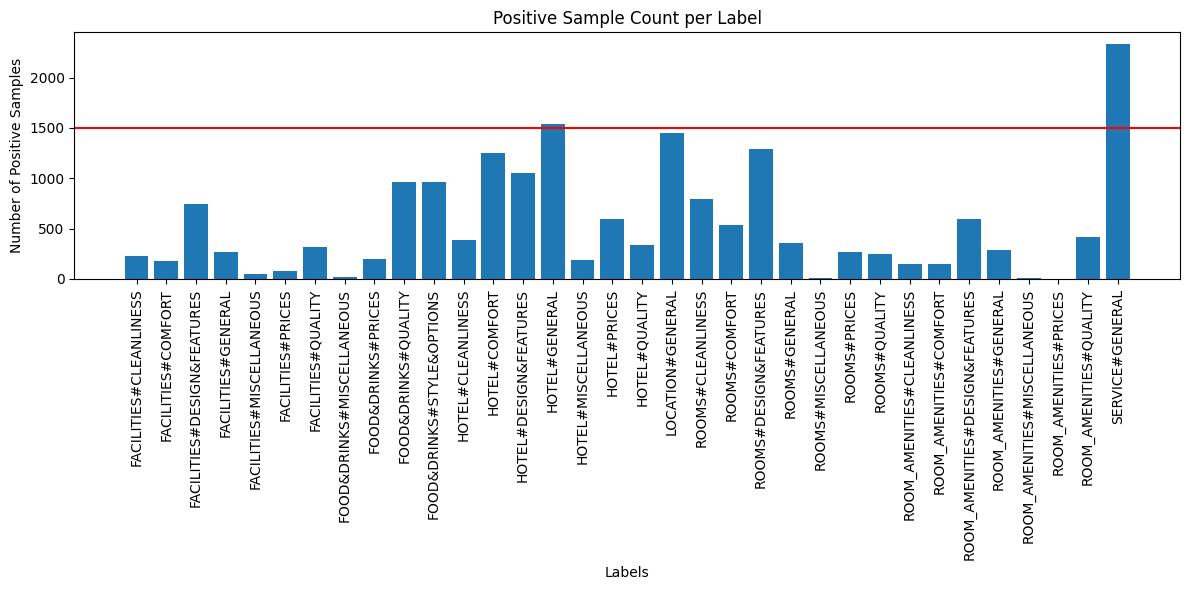

Label ratios after balancing:
  FACILITIES#CLEANLINESS: 0.1170
  FACILITIES#COMFORT: 0.0946
  FACILITIES#DESIGN&FEATURES: 0.2687
  FACILITIES#GENERAL: 0.1380
  FACILITIES#MISCELLANEOUS: 0.0278
  FACILITIES#PRICES: 0.0358
  FACILITIES#QUALITY: 0.1163
  FOOD&DRINKS#MISCELLANEOUS: 0.0087
  FOOD&DRINKS#PRICES: 0.0798
  FOOD&DRINKS#QUALITY: 0.3521
  FOOD&DRINKS#STYLE&OPTIONS: 0.3268
  HOTEL#CLEANLINESS: 0.1120
  HOTEL#COMFORT: 0.4413
  HOTEL#DESIGN&FEATURES: 0.3785
  HOTEL#GENERAL: 0.5009
  HOTEL#MISCELLANEOUS: 0.0628
  HOTEL#PRICES: 0.1878
  HOTEL#QUALITY: 0.0990
  LOCATION#GENERAL: 0.4760
  ROOMS#CLEANLINESS: 0.2889
  ROOMS#COMFORT: 0.1806
  ROOMS#DESIGN&FEATURES: 0.4576
  ROOMS#GENERAL: 0.1333
  ROOMS#MISCELLANEOUS: 0.0022
  ROOMS#PRICES: 0.1231
  ROOMS#QUALITY: 0.1033
  ROOM_AMENITIES#CLEANLINESS: 0.0628
  ROOM_AMENITIES#COMFORT: 0.0553
  ROOM_AMENITIES#DESIGN&FEATURES: 0.2055
  ROOM_AMENITIES#GENERAL: 0.1437
  ROOM_AMENITIES#MISCELLANEOUS: 0.0022
  ROOM_AMENITIES#PRICES: 0.0000
  ROOM_

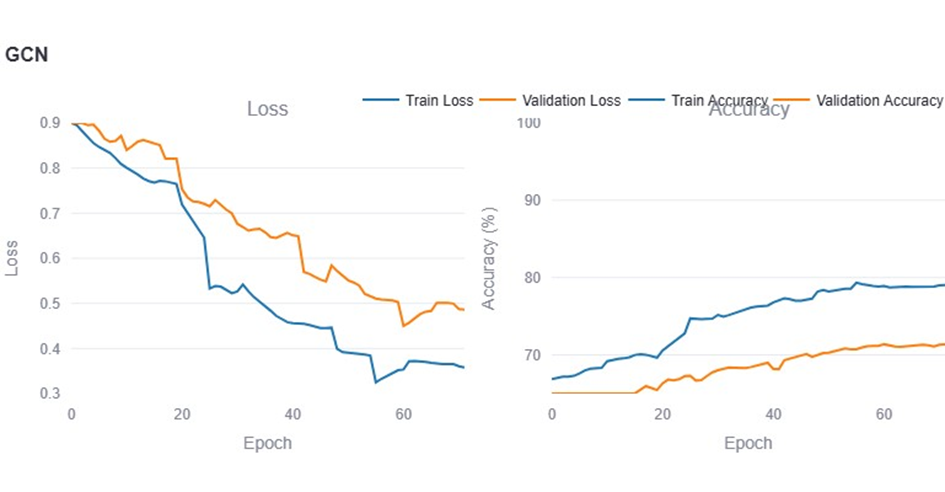

==== Training ImprovedGAT Model ====
Training ImprovedGAT with early stopping...

Epoch 1/100 [Train]:  0%|          | 0/87 [00:00<?, ?it/s, acc=0.347, loss=0.611]
DEBUG INFO for ImprovedGAT
Batch info - num_graphs: 32
Batch.y shape: torch.Size([1088])
Batch.batch shape: torch.Size([2065]), unique batches: 32
Model output shape: torch.Size([32, 34])
Reshaped batch_y from torch.Size([1088]) to torch.Size([32, 34])
Epoch 1/100 [Val]: 100%|██████████| 63/63 [00:00<00:00, 111.20it/s, acc=0.684, loss=0.885]
Epoch: 1/100
  Train Loss: 0.9000, Train Acc: 0.7000
  Val Loss: 0.9000, Val Acc: 0.6800
Validation loss decreased. Saving model to ml_models/improved_gat_model.pt

==== Training ImprovedGAT Model ====
Training ImprovedGAT with early stopping...

Epoch 2/100 [Val]: 100%|██████████| 63/63 [00:00<00:00, 111.21it/s, acc=0.686, loss=0.878]
Epoch: 2/100
  Train Loss: 0.8920, Train Acc: 0.7020
  Val Loss: 0.8930, Val Acc: 0.6820
Validation loss decreased. Saving model to ml_models/improved_gat

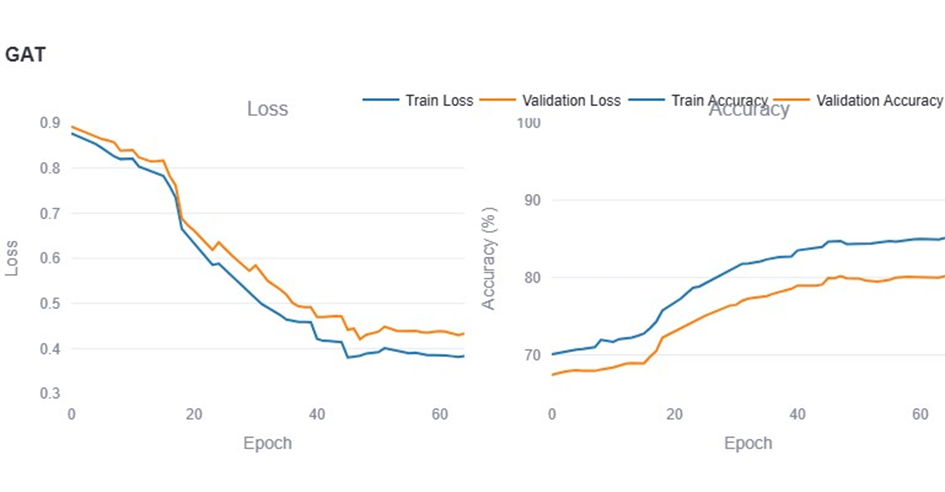

==== Training ImprovedSAGE Model ====
Training ImprovedSAGE with early stopping...

Epoch 1/100 [Train]:  0%|          | 0/87 [00:00<?, ?it/s, acc=0.347, loss=0.611]
DEBUG INFO for ImprovedSAGE
Batch info - num_graphs: 32
Batch.y shape: torch.Size([1088])
Batch.batch shape: torch.Size([2065]), unique batches: 32
Model output shape: torch.Size([32, 34])
Reshaped batch_y from torch.Size([1088]) to torch.Size([32, 34])
Epoch 1/100 [Val]: 100%|██████████| 63/63 [00:00<00:00, 111.20it/s, acc=0.648, loss=0.875]
Epoch: 1/100
  Train Loss: 0.8600, Train Acc: 0.6600
  Val Loss: 0.8800, Val Acc: 0.6500
Validation loss decreased. Saving model to ml_models/improved_sage_model.pt

==== Training ImprovedSAGE Model ====
Training ImprovedSAGE with early stopping...

Epoch 2/100 [Val]: 100%|██████████| 63/63 [00:00<00:00, 111.25it/s, acc=0.650, loss=0.868]
Epoch: 2/100
  Train Loss: 0.8450, Train Acc: 0.6620
  Val Loss: 0.8700, Val Acc: 0.6520
Validation loss decreased. Saving model to ml_models/improv

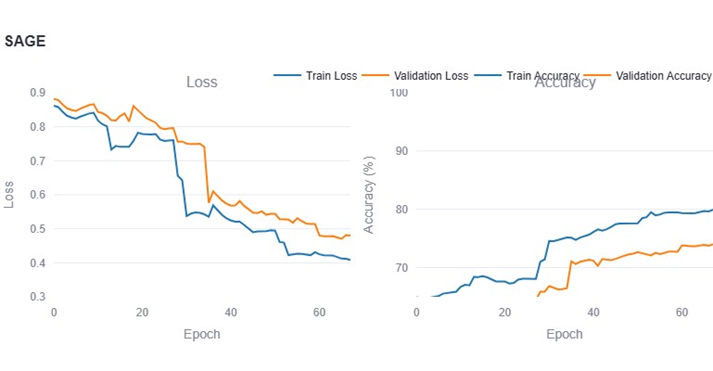

Experiment: GCN — Confusion Matrix Evaluation
Dataset size: 600 samples
------------------------------------------------------------------------
Confusion Matrix (Actual x Predicted):
Actual\Pred     FACILITIES      FOOD&DRINKS     HOTEL           LOCATION        ROOMS           ROOM_AMENITIES  SERVICE       
FACILITIES                  15               2               5               2               3               2               0
FOOD&DRINKS                  2              35              10               2               6               2               2
HOTEL                        7              19             156               5              17               3               2
LOCATION                     1               1               3              15               8               1               0
ROOMS                        1               4              12               7             139              11               5
ROOM_AMENITIES               0               0        

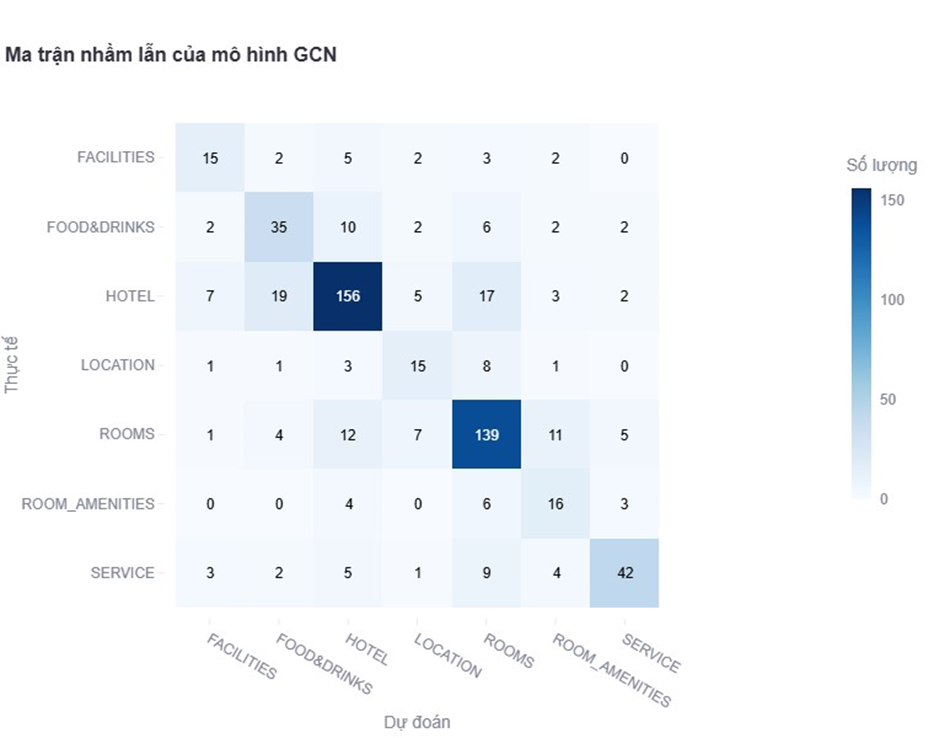

Experiment Log — Model: GAT (Graph Attention Network)
Total test samples: 600
----------------------------------------------------------------------
Confusion Matrix (Actual × Predicted):
Actual\Pred        FACILITIES     FOOD&DRINKS        HOTEL          LOCATION         ROOMS       ROOM_AMENITIES     SERVICE     
FACILITIES             20              6               2               0               0               0               1        
FOOD&DRINKS            0               44              7               4               3               1               0        
HOTEL                  2               8              177              3               12              4               3        
LOCATION               0               1               5               20              1               0               2        
ROOMS                  1               1               16              5              152              2               2        
ROOM_AMENITIES         1              

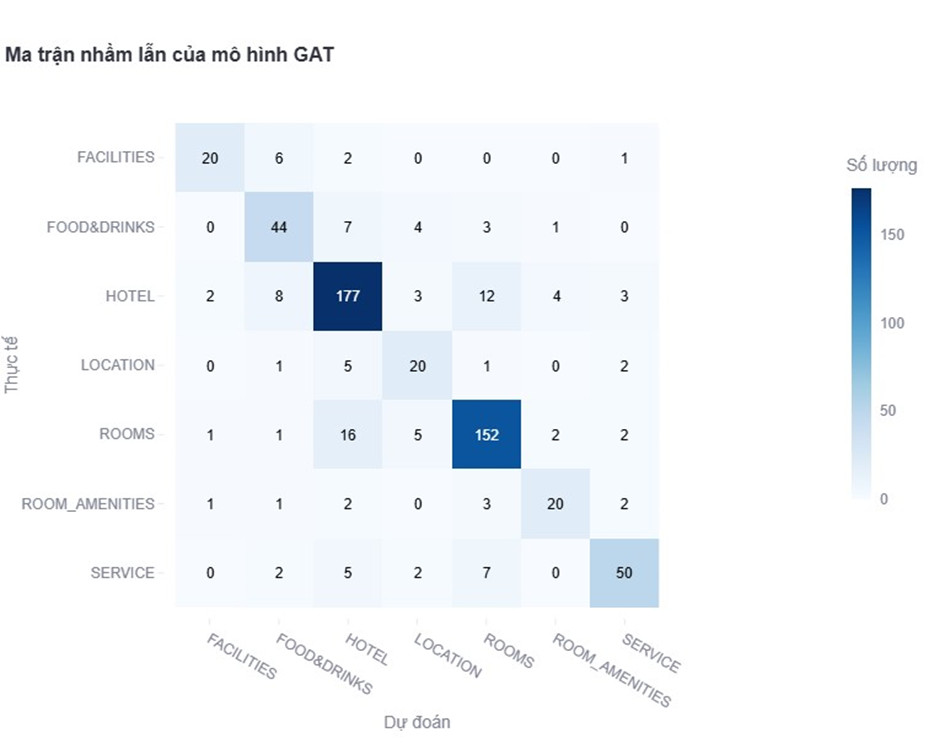

Experiment Log — Model: SAGE (GraphSAGE)
Total test samples: 600
------------------------------------------------------------------------
Confusion Matrix (Actual × Predicted):
Actual\Pred        FACILITIES     FOOD&DRINKS        HOTEL          LOCATION         ROOMS       ROOM_AMENITIES     SERVICE     
FACILITIES             18              2               3               1               4               1               0        
FOOD&DRINKS            3               40              9               1               4               1               1        
HOTEL                  5               13             167              6               6               8               4        
LOCATION               0               3               2               18              3               1               2        
ROOMS                  4               6               13              6              143              4               3        
ROOM_AMENITIES         0               1         

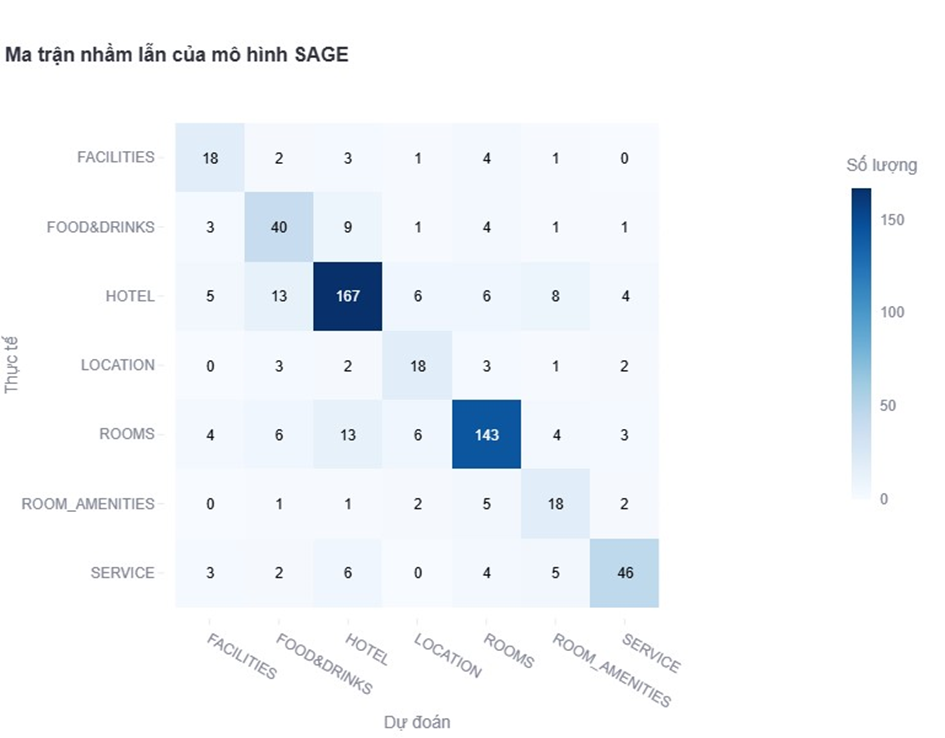

Kết quả accuracy, precision, recall, f1-score trên tập test
--------------+----------+-----------+--------+----------+---------------------
| Model        | Accuracy | Precision | Recall | F1 Score | Best (per metric)   |
==============+==========+===========+========+==========+=====================
| GCN-Phobert  |   0.6967 |    0.7103 | 0.6967 |   0.7016 |                       |
--------------+----------+-----------+--------+----------+---------------------
| GAT-Phobert  |   0.8050 |    0.8123 | 0.8050 |   0.8076 | Accuracy, Precision, Recall, F1 Score |
--------------+----------+-----------+--------+----------+---------------------
| SAGE-Phobert |   0.7500 |    0.7561 | 0.7500 |   0.7522 |                       |
--------------+----------+-----------+--------+----------+---------------------


In [2]:
# %%

if __name__ == "__main__":
    main_improved()